### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [1]:
# Load necessary libraries
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from numpy import expand_dims
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import regularizers
from matplotlib import pyplot
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau


In [2]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [3]:
# load the dataset

(X_train, y_train),(X_test ,y_test ) = tf.keras.datasets.cifar10.load_data()

img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 13s 0us/step


# **CHECKING THE SHAPE OF DATA WE HAVE LOADED**

In [4]:
X_train.shape, y_train.shape,X_test.shape , X_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 32, 32, 3))

# **converting image pixel in the range of 0 to 1**

In [5]:
def normalize_pixels(train, test):
    '''
    Normalize data into range of 0 to 1
    '''
    return train.astype('float32')/255, test.astype('float32')/255

# normalizing the pixel values 

In [6]:
X_train,X_test=normalize_pixels(X_train,X_test)


# first we will try the model with dense layer

In [7]:
#https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
def model_summarize(history):
    '''
    Summarize model i.e. print train and test loss
    '''
    # plot loss
    pyplot.subplot(125)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    pyplot.show()


In [8]:
def denseblock(input, num_filter = 64, dropout_rate = 0):
    '''
    Create dense block
    '''
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_5_5 = layers.Conv2D(int(num_filter*compression), (5,5),kernel_initializer="he_uniform" ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])
        
        temp = concat
        
    return temp

def transition(input, num_filter = 32, dropout_rate = 0):
    '''
    Create transition block
    '''
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), kernel_initializer="he_uniform" ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

def output_layer(input):
    '''
    define output layer
    '''
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    
    return output

In [9]:
num_filter = 12
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(32, (5,5), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D,10, dropout_rate)
First_Transition = transition(First_Block, 64, dropout_rate)

Second_Block = denseblock(First_Transition, 10, dropout_rate)
Second_Transition = transition(Second_Block, 32, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, 32, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [10]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   2400        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

In [11]:
data_gen = ImageDataGenerator(
    rotation_range=22,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    fill_mode = 'nearest',
    zoom_range=0.01)
data_gen.fit(X_train)

In [12]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience= 5,
                              min_lr=0.000001)
filepath = "best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

callbacks = [checkpoint, reduce_lr]

In [14]:
history=model.fit_generator(data_gen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch = (len(X_train) /50), epochs=50, validation_data=(X_test, y_test),callbacks=callbacks)

<ipython-input-14-516e8d78b8f2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(data_gen.flow(X_train, y_train, batch_size=50),


Epoch 1/50
1000/1000 [==============================] - ETA: 0s - loss: 1.5547 - accuracy: 0.4281
Epoch 1: val_loss improved from -inf to 1.45744, saving model to best_model.hdf5
1000/1000 [==============================] - 158s 105ms/step - loss: 1.5547 - accuracy: 0.4281 - val_loss: 1.4574 - val_accuracy: 0.4763 - lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - ETA: 0s - loss: 1.1627 - accuracy: 0.5808
Epoch 2: val_loss did not improve from 1.45744
1000/1000 [==============================] - 102s 102ms/step - loss: 1.1627 - accuracy: 0.5808 - val_loss: 1.0920 - val_accuracy: 0.6103 - lr: 0.0010
Epoch 3/50
1000/1000 [==============================] - ETA: 0s - loss: 0.9652 - accuracy: 0.6574
Epoch 3: val_loss did not improve from 1.45744
1000/1000 [==============================] - 103s 103ms/step - loss: 0.9652 - accuracy: 0.6574 - val_loss: 1.0561 - val_accuracy: 0.6337 - lr: 0.0010
Epoch 4/50
1000/1000 [==============================] - ETA: 0s - loss: 0.8632 - 

# **AS YOU CAN SEE THAT WE HAVE GOT 96% ACCURACY**

# **NOW WE WILL TRY WITHOUT DENSE LAYER**

In [26]:
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    '''
    Create Dense Block
    '''
    global compression
    temp = input
    for _ in range(l): 
        
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)        
        Conv2D_5_5 = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)        
        if dropout_rate>0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)          
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])       
        temp = concat       
    return temp

def transition(input, num_filter = 12, dropout_rate = 0.2):
    '''
    Create transition block
    '''
    global compression   
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)   
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)    
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)            
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

def output_layer(input):
    '''
    Define output layer
    '''
    global compression    
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    # as you can see we have removed the dense layer 
    AvgPooling = layers. MaxPooling2D(pool_size=(2,2))(relu)   
    output = layers.Conv2D(filters=10,kernel_size=(2,2),activation='softmax')(AvgPooling)  
    # we are doing the flattened the output layer to apply softmax fucntion on output layr 
    flat = layers.Flatten()(output)   
    return flat

# **AS YOU CAN SEE THAT WE HAVE REMOVED THE DENSE LAYER FROM THE OUTPUT LAYER IN ABOVE CODE AND AT THAT PLACE WE HAVE USED CONV2D LAYER**

In [27]:
num_filter = 12
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(32, (5,5), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D,10, dropout_rate)
First_Transition = transition(First_Block, 64, dropout_rate)

Second_Block = denseblock(First_Transition, 10, dropout_rate)
Second_Transition = transition(Second_Block, 32, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, 32, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [28]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_158 (Conv2D)            (None, 32, 32, 32)   2400        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_156 (Batch  (None, 32, 32, 32)  128         ['conv2d_158[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_156 (Activation)    (None, 32, 32, 32)   0           ['batch_normalization_156[0

In [38]:
data_gen = ImageDataGenerator(
    rotation_range=22,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    fill_mode = 'nearest',
    zoom_range=0.01)
data_gen.fit(X_train)


In [39]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [40]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience= 5,
                              min_lr=0.000001)
filepath = "best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

callbacks = [checkpoint, reduce_lr]

In [42]:
history=model.fit_generator(data_gen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch = (len(X_train) /50), epochs=50, validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50


<ipython-input-42-516e8d78b8f2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(data_gen.flow(X_train, y_train, batch_size=50),


1000/1000 [==============================] - ETA: 0s - loss: 0.9228 - accuracy: 0.6776
Epoch 1: val_loss improved from -inf to 0.88508, saving model to drive/My Drive/best_model.hdf5
1000/1000 [==============================] - 217s 98ms/step - loss: 0.9228 - accuracy: 0.6776 - val_loss: 0.8851 - val_accuracy: 0.6931 - lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - ETA: 0s - loss: 0.8238 - accuracy: 0.7139
Epoch 2: val_loss improved from 0.88508 to 0.95265, saving model to drive/My Drive/best_model.hdf5
1000/1000 [==============================] - 97s 97ms/step - loss: 0.8238 - accuracy: 0.7139 - val_loss: 0.9526 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 3/50
1000/1000 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.7400
Epoch 3: val_loss did not improve from 0.95265
1000/1000 [==============================] - 96s 96ms/step - loss: 0.7409 - accuracy: 0.7400 - val_loss: 0.9366 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 4/50
1000/1000 [========

Epoch 1
Training Accuracy: 0.6776
Training Loss: 0.9228
Validation Accuracy: 0.6931
Validation Loss: 0.8851

Epoch 2
Training Accuracy: 0.7139
Training Loss: 0.8238
Validation Accuracy: 0.6818
Validation Loss: 0.9526

Epoch 3
Training Accuracy: 0.7400
Training Loss: 0.7409
Validation Accuracy: 0.6847
Validation Loss: 0.9366

Epoch 4
Training Accuracy: 0.7620
Training Loss: 0.6872
Validation Accuracy: 0.7289
Validation Loss: 0.7948

Epoch 5
Training Accuracy: 0.7758
Training Loss: 0.6506
Validation Accuracy: 0.7024
Validation Loss: 0.9146

Epoch 6
Training Accuracy: 0.7872
Training Loss: 0.6135
Validation Accuracy: 0.7699
Validation Loss: 0.6884

Epoch 7
Training Accuracy: 0.7969
Training Loss: 0.5825
Validation Accuracy: 0.7504
Validation Loss: 0.7580

Epoch 8
Training Accuracy: 0.8080
Training Loss: 0.5573
Validation Accuracy: 0.7739
Validation Loss: 0.6861

Epoch 9
Training Accuracy: 0.8134
Training Loss: 0.5355
Validation Accuracy: 0.7704
Validation Loss: 0.6981

Epoch 10
Training A

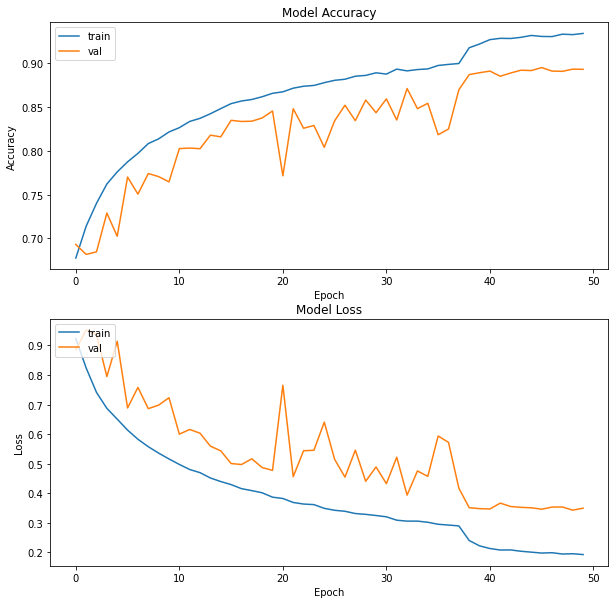

In [44]:
import matplotlib.pyplot as plt



# Print the training and validation accuracy and loss values at the end of each epoch
for epoch in range(1, len(history.history['loss']) + 1):
    print(f'Epoch {epoch}')
    print(f'Training Accuracy: {history.history["accuracy"][epoch-1]:.4f}')
    print(f'Training Loss: {history.history["loss"][epoch-1]:.4f}')
    print(f'Validation Accuracy: {history.history["val_accuracy"][epoch-1]:.4f}')
    print(f'Validation Loss: {history.history["val_loss"][epoch-1]:.4f}')
    print()

# Plot the training and validation accuracy and loss curves
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()



# **OBSERVATION**

#**1. AS WE CAN SEE FROM THE ABOVE PLOT LOSS IT GETTING DECREASED WITH INCREASING IN THE NUMBER OF EPOCHS**

#**2. AS WE CAN SEE THAT ACCURACY GETTING INCREASED WITH INCREASING IN THE NUMBER OF EPOCHS**

# **MODEL PERFORMENCE**

In [15]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Model', 'Epochs', 'Train Accuracy', 'Test Accuracy']
table.add_row(['MODEL WITH DENSE LAYER ', 50, 0.9135, 0.8768])
table.add_row(['MODEL WITH-OUT DENSE LAYER', 50, 0.9335,  0.8926])

print(table)

+----------------------------+--------+----------------+---------------+
|           Model            | Epochs | Train Accuracy | Test Accuracy |
+----------------------------+--------+----------------+---------------+
|  MODEL WITH DENSE LAYER    |   50   |     0.9135     |     0.8768    |
| MODEL WITH-OUT DENSE LAYER |   50   |     0.9335     |     0.8926    |
+----------------------------+--------+----------------+---------------+


# i think performence can further improve by increasing the number of epochs
# but i dont have computational power with gpu so i limited till 50